# Import Libraries and Load Data

In [ ]:
import medmnist
from medmnist import INFO, BloodMNIST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.feature import hog, graycomatrix, graycoprops
from skimage import io, color, exposure, filters

import cv2
from skimage import morphology, measure
from skimage.color import rgb2gray
import random

In [ ]:
# Load the BloodMNIST dataset with high resolution for all splits
train_data = BloodMNIST(split='train', download=True, as_rgb=True, size=224)
val_data = BloodMNIST(split='val', download=True, as_rgb=True, size=224)
test_data = BloodMNIST(split='test', download=True, as_rgb=True, size=224)

Using downloaded and verified file: /Users/lowi33/.medmnist/bloodmnist_224.npz
Using downloaded and verified file: /Users/lowi33/.medmnist/bloodmnist_224.npz
Using downloaded and verified file: /Users/lowi33/.medmnist/bloodmnist_224.npz


# See Class Distribution

In [ ]:
train_data

Dataset BloodMNIST of size 224 (bloodmnist_224)
    Number of datapoints: 11959
    Root location: /Users/lowi33/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'Immature Granulocytes', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0

In [ ]:
# Get dataset information
blood_info = INFO['bloodmnist']
n_classes_blood = len(blood_info['label'])

# Get the class labels
class_labels_blood = blood_info['label']
class_labels_blood['3'] = 'Immature Granulocytes'

# Count the number of instances for each class in BloodMNIST
label_counts_blood = Counter([int(label) for _, label in train_data])

In [ ]:
# Print the distribution of class labels for BloodMNIST
print("\nClass Label Distribution in BloodMNIST:")
for key, count in label_counts_blood.items():
    print(f"Class {key}: {count} instances")


Class Label Distribution in BloodMNIST:
Class 7: 1643 instances
Class 3: 2026 instances
Class 6: 2330 instances
Class 2: 1085 instances
Class 1: 2181 instances
Class 5: 993 instances
Class 0: 852 instances
Class 4: 849 instances


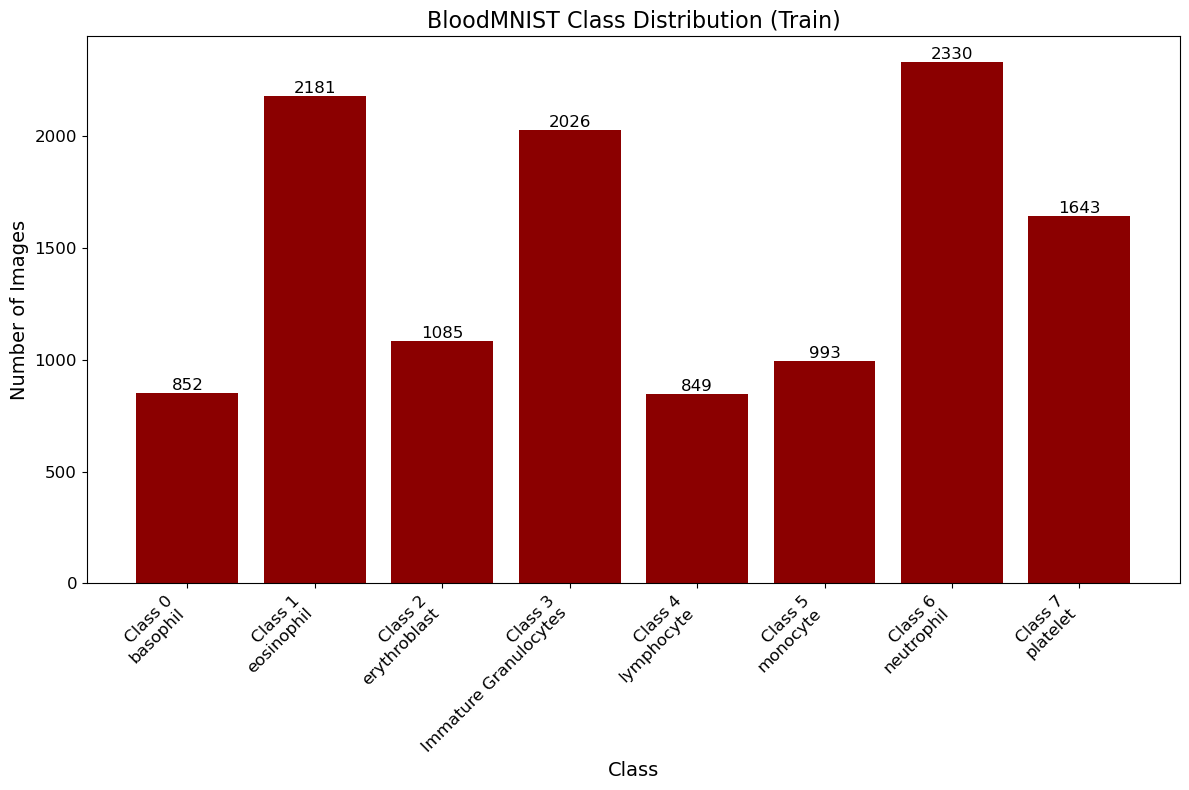

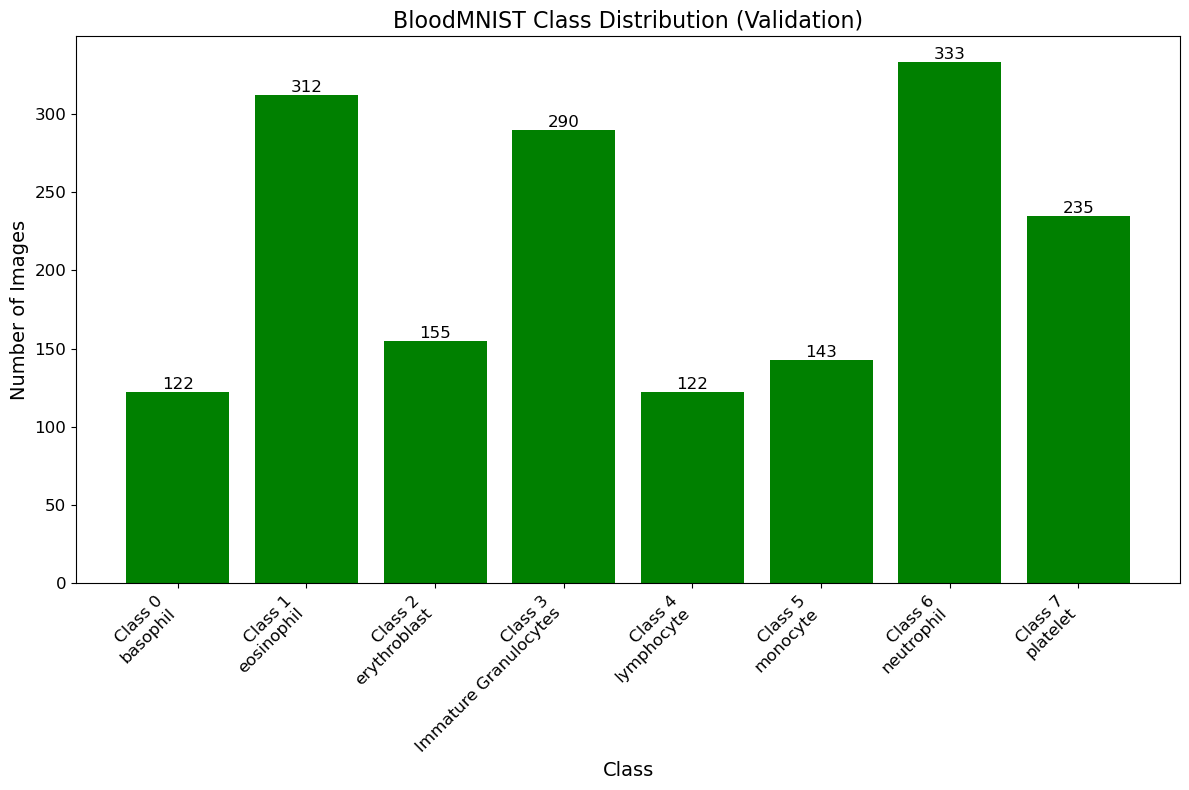

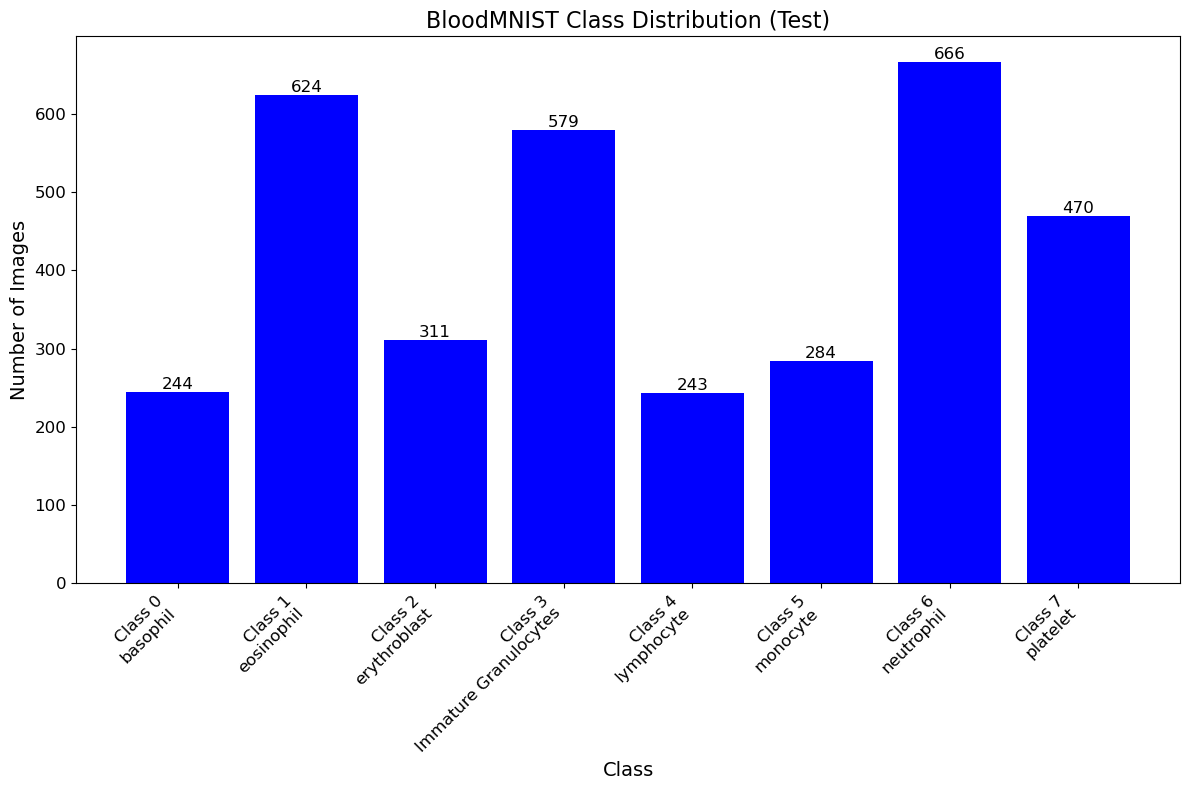

In [ ]:
# Count the number of instances for each class in each split
label_counts_train = Counter([int(label) for _, label in train_data])
label_counts_val = Counter([int(label) for _, label in val_data])
label_counts_test = Counter([int(label) for _, label in test_data])

def plot_class_distribution(label_counts, class_labels, title, color):
    classes = list(range(len(class_labels)))  # Ensure all classes are shown
    counts = [label_counts.get(i, 0) for i in classes]
    labels = [f"Class {i}\n{class_labels[str(i)]}" for i in classes]

    plt.figure(figsize=(12, 8))
    bars = plt.bar(classes, counts, tick_label=labels, color=color)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    # Add data labels on top of each column
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

# Plot BloodMNIST class distribution
plot_class_distribution(label_counts_train, class_labels_blood, 'BloodMNIST Class Distribution (Train)', 'darkred')
plot_class_distribution(label_counts_val, class_labels_blood, 'BloodMNIST Class Distribution (Validation)', 'green')
plot_class_distribution(label_counts_test, class_labels_blood, 'BloodMNIST Class Distribution (Test)', 'blue')


# Image Preprocessing

- **Binary Thresholding**: Convert images to grayscale and apply a binary threshold to segment the target cells. This step helps in isolating the cells from the background by converting the image to black and white based on a threshold value.

- **Noise Reduction**: Remove small objects from the binary image to focus on the most significant parts of the image (i.e., target cells)

- **Component Labeling**: Label connected components in the binary image and retain the largest connected component, assuming it's the target cell. This step ensures that only the most relevant part of the image is considered.

- **Masking**: Apply the binary mask to the original image to highlight the target cells while suppressing the background and other irrelevant objects.

- **Data Conversion**: Use a class to convert the preprocessed data back to the original data format, which maintains compatibility with PyTorch methods while preserving the data structure for model training and evaluation.


In [ ]:
def preprocess_image(image):
    # Convert to grayscale
    gray = rgb2gray(image)

    # Apply Gaussian blur to reduce noise and smooth the image
    blurred = cv2.GaussianBlur((gray * 255).astype(np.uint8), (5, 5), 0)

    # Apply a binary threshold to segment the target cells
    _, binary = cv2.threshold((gray * 255).astype(np.uint8), 128, 255, cv2.THRESH_BINARY_INV)

    # Remove small objects from the binary image
    cleaned = morphology.remove_small_objects(binary > 0, min_size=500)

    # Label the connected components
    labeled, num_labels = measure.label(cleaned, return_num=True, connectivity=2)

    # Keep the largest connected component (assuming it's the target cell)
    largest_component = morphology.remove_small_objects(labeled, min_size=500)

    # Mask the original image
    masked_image = image * np.dstack([largest_component > 0] * 3)

    return masked_image

In [ ]:
def show_comparison(dataset, n_images=5):
    """Show comparison of original image to preprocessed image"""
    fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))

    for i in range(n_images):
        # Randomly select an image from the dataset
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        preprocessed_img = preprocess_image(np.array(img))

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original Image - Class {int(label)}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(preprocessed_img)
        axes[i, 1].set_title(f"Preprocessed Image - Class {int(label)}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def preprocess_dataset(dataset):
    """Pre-process the entire dataset"""
    preprocessed_data = []
    for img, label in dataset:
        preprocessed_img = preprocess_image(np.array(img))
        preprocessed_data.append((preprocessed_img, label))
    return preprocessed_data

# Preprocess and overwrite the datasets
train_data_preprocessed = preprocess_dataset(train_data)
val_data_preprocessed = preprocess_dataset(val_data)
test_data_preprocessed = preprocess_dataset(test_data)


/var/folders/lh/xjdvj6w17sb4ymqrg_4w1yfw0000gp/T/ipykernel_96080/251657343.py:18: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  largest_component = morphology.remove_small_objects(labeled, min_size=500)


In [ ]:
# Convert preprocessed data back to original data format
class PreprocessedDataset:
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        img, label = self.data[index]
        return img, label

    def __len__(self):
        return len(self.data)

# Create dataset objects
train_data_preprocessed = PreprocessedDataset(train_data_preprocessed)
val_data_preprocessed = PreprocessedDataset(val_data_preprocessed)
test_data_preprocessed = PreprocessedDataset(test_data_preprocessed)

# Display Images

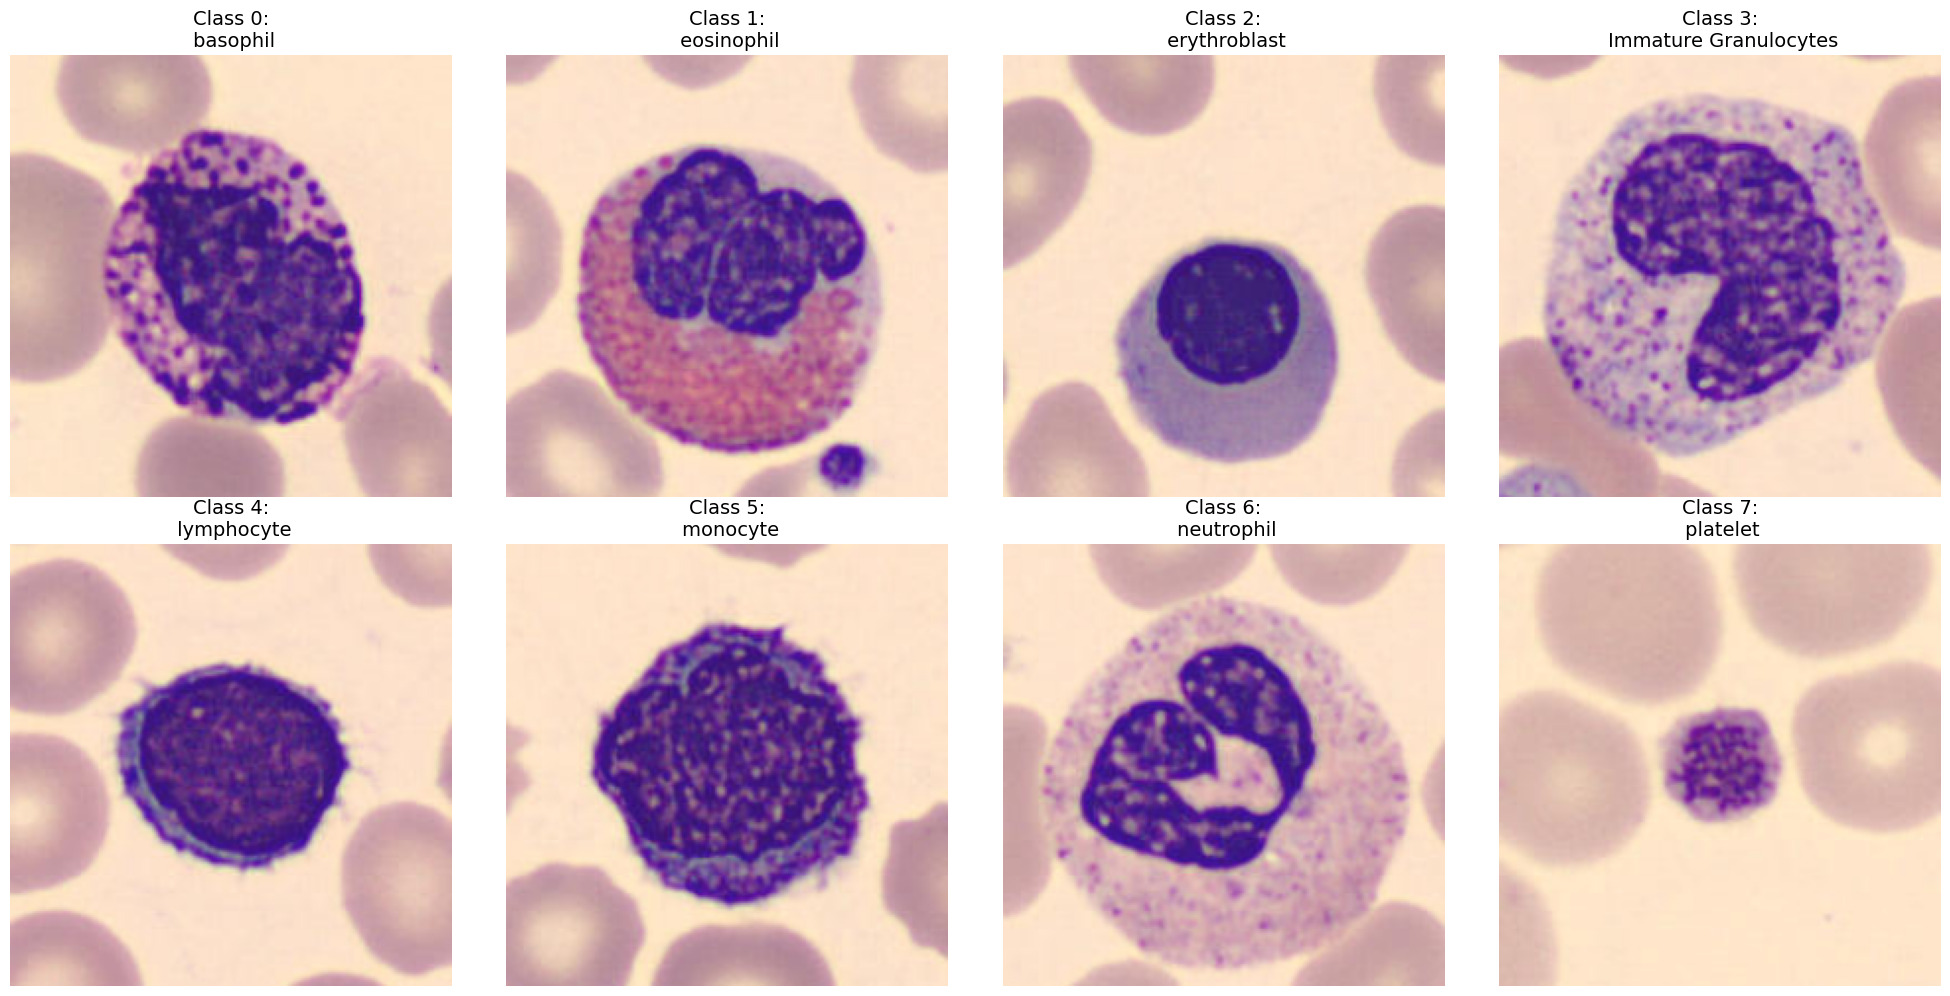

In [ ]:
def show_one_image_per_class(dataset, n_classes, class_labels):
    """Randomly show one pre-processed image per class"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    class_found = [False] * n_classes

    # Create a dictionary to store images by class
    class_images = {i: [] for i in range(n_classes)}
    for img, label in dataset:
        label = int(label)
        class_images[label].append(img)

    for class_idx in range(n_classes):
        if class_images[class_idx]:
            random_img = random.choice(class_images[class_idx])
            axes[class_idx].imshow(random_img)
            axes[class_idx].set_title(f"Class {class_idx}:\n {class_labels[str(class_idx)]}", fontsize=14)
            axes[class_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Show one example image from the preprocessed training dataset for each class
show_one_image_per_class(train_data, n_classes_blood, class_labels_blood)

/var/folders/lh/xjdvj6w17sb4ymqrg_4w1yfw0000gp/T/ipykernel_96080/251657343.py:18: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  largest_component = morphology.remove_small_objects(labeled, min_size=500)


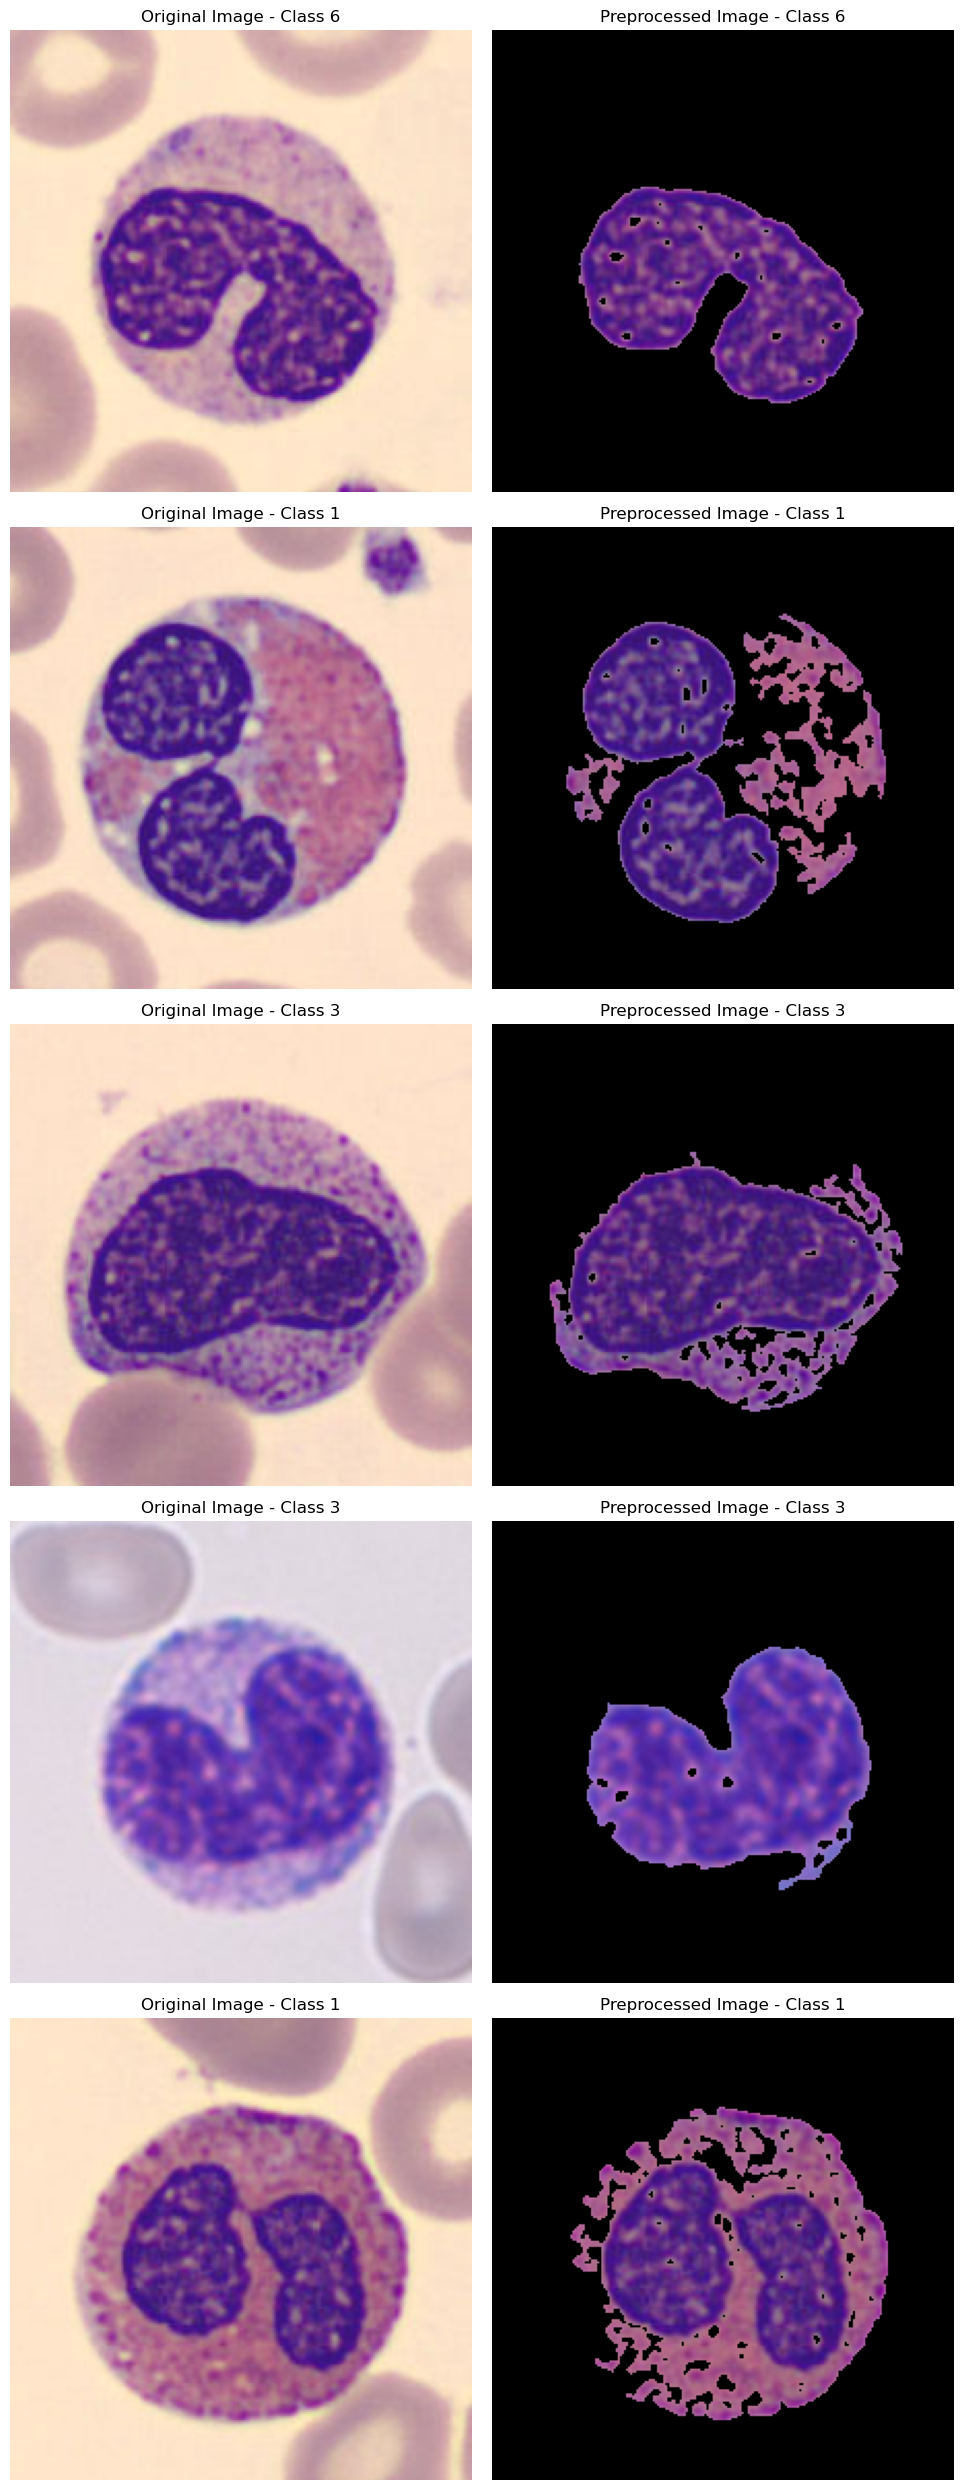

In [ ]:
# Show comparison for 5 random images from the training dataset to showcase the pre-processing transformations
show_comparison(train_data, n_images=5)

# Feature Engineering
- Simple Feature: Edges
    - Edge detection can highlight the boundaries of cells, which is crucial for distinguishing between different types of blood cells based on their shape and size. Using edge detection algorithms can provide valuable information about cell morphology.

- Simple Feature: Color Histograms
    - Color histograms represent the distribution of colors in an image and can help differentiate between cell types based on color variations. This is particularly useful for identifying cell types like eosinophils and basophils, which have distinct color characteristics.

- Complex Feature: Texture Analysis
    - Texture analysis involves examining the surface characteristics of cells, which can be quantified using methods like Local Binary Patterns (LBP) or Gray Level Co-occurrence Matrix (GLCM). Texture features can provide deeper insights into the cell structure, helping to distinguish between similar looking cell types.


## Edge Detection

In [ ]:
def extract_edge_features(image):
    edges = cv2.Canny((rgb2gray(image) * 255).astype(np.uint8), 100, 200)
    return edges.flatten()

In [ ]:
def show_edge_detection(dataset, n_images=5):
    """Show edge detection results for a number of images"""
    fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))

    for i in range(n_images):
        # Randomly select an image from the dataset
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        preprocessed_img = preprocess_image(np.array(img))
        edges = cv2.Canny((rgb2gray(img) * 255).astype(np.uint8), 100, 200)

        axes[i, 0].imshow(preprocessed_img)
        axes[i, 0].set_title(f"Preprocessed Image - Class {int(label)}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(edges, cmap='gray')
        axes[i, 1].set_title(f"Edges - Class {int(label)}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

/var/folders/lh/xjdvj6w17sb4ymqrg_4w1yfw0000gp/T/ipykernel_96080/251657343.py:18: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  largest_component = morphology.remove_small_objects(labeled, min_size=500)


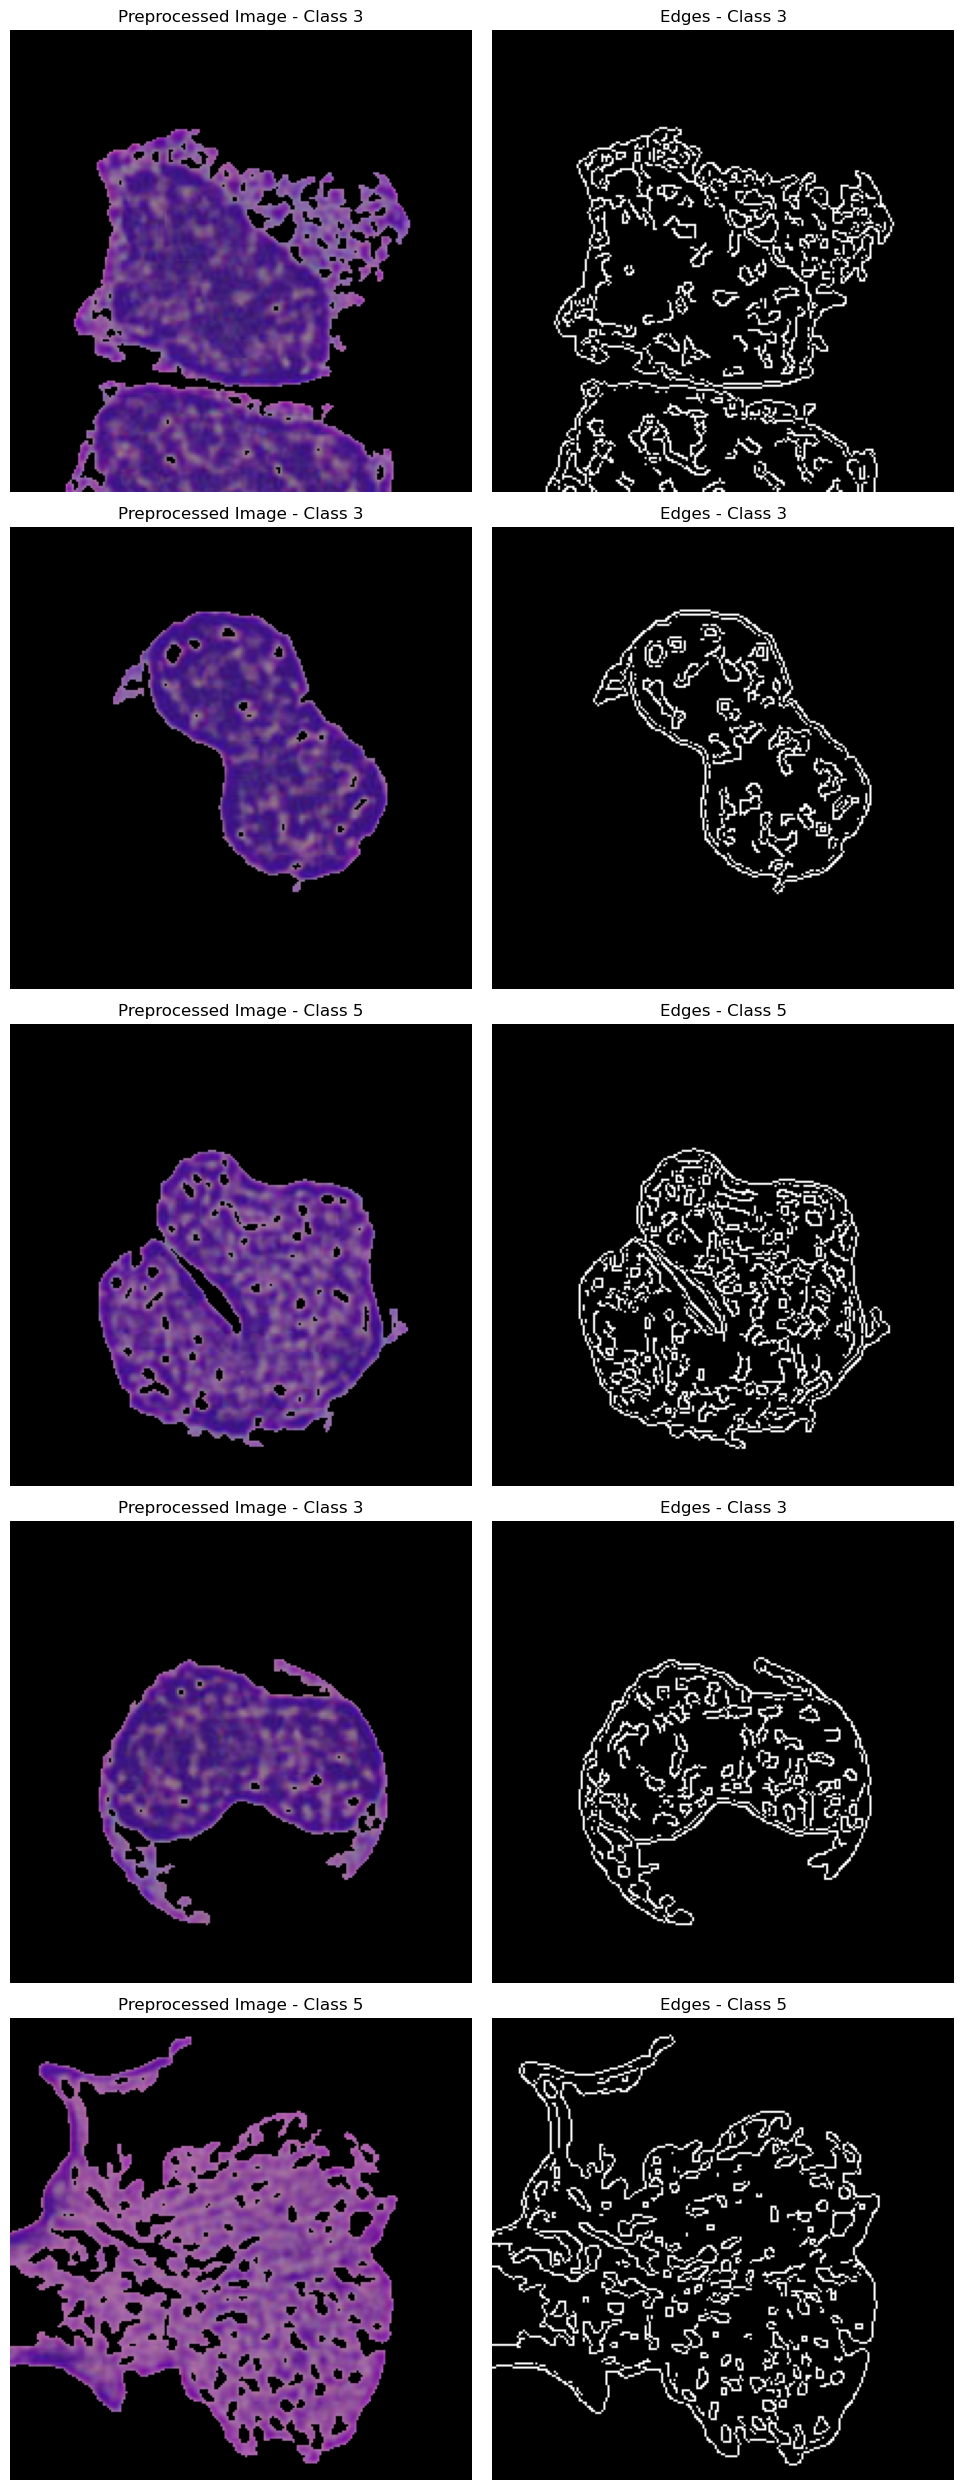

In [ ]:
show_edge_detection(train_data_preprocessed)

## Color Histograms

In [ ]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    # Convert PIL Image to NumPy array
    image = np.array(image)

    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Compute the color histogram
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])

    # Normalize the histogram
    hist = cv2.normalize(hist, hist).flatten()

    return hist

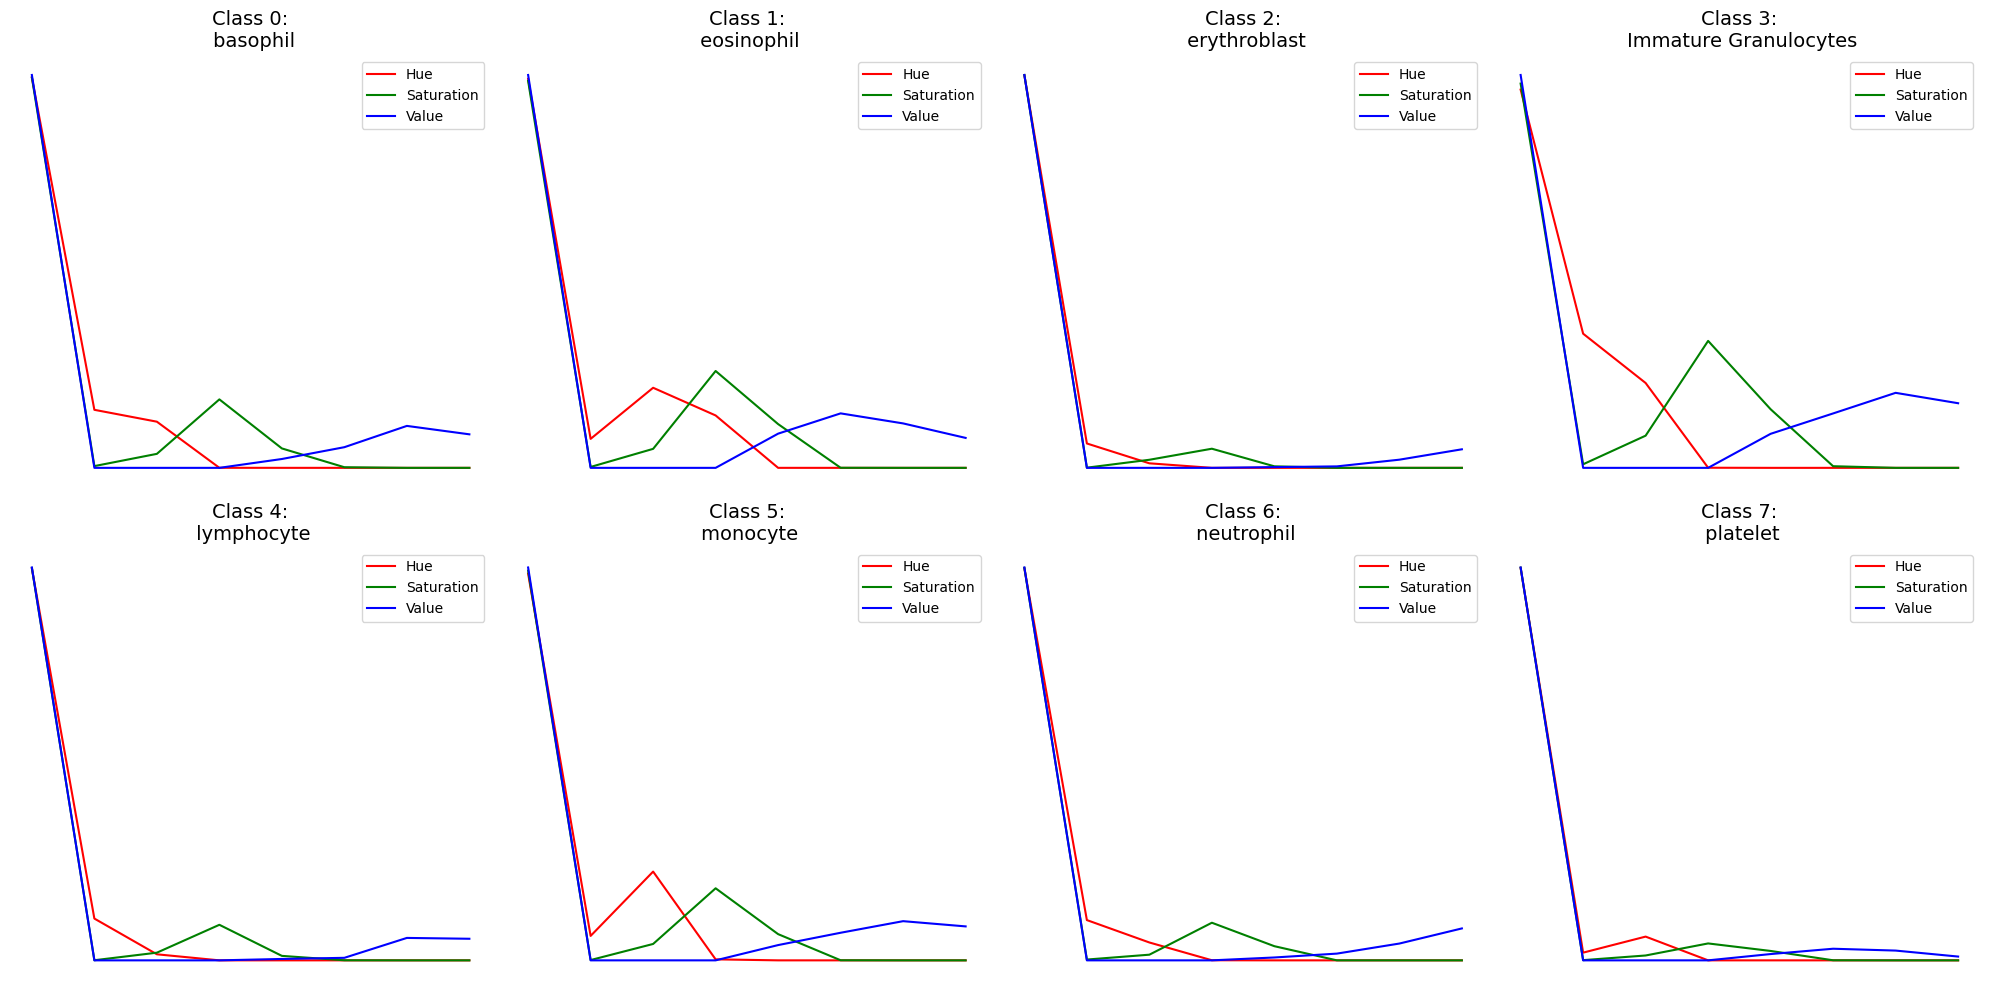

In [ ]:
def show_color_histograms(dataset, n_classes, class_labels, bins=(8, 8, 8)):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    class_found = [False] * n_classes

    # Create a dictionary to store images by class
    class_images = {i: [] for i in range(n_classes)}
    for img, label in dataset:
        label = int(label)
        class_images[label].append(img)

    for class_idx in range(n_classes):
        if class_images[class_idx]:
            random_img = random.choice(class_images[class_idx])
            hsv = cv2.cvtColor((random_img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)

            # Compute the histograms for each channel
            hist_hue = cv2.calcHist([hsv], [0], None, [bins[0]], [0, 180])
            hist_saturation = cv2.calcHist([hsv], [1], None, [bins[1]], [0, 256])
            hist_value = cv2.calcHist([hsv], [2], None, [bins[2]], [0, 256])

            # Normalize the histograms
            hist_hue = cv2.normalize(hist_hue, hist_hue).flatten()
            hist_saturation = cv2.normalize(hist_saturation, hist_saturation).flatten()
            hist_value = cv2.normalize(hist_value, hist_value).flatten()

            # Plot histograms
            axes[class_idx].plot(hist_hue, color='r', label='Hue')
            axes[class_idx].plot(hist_saturation, color='g', label='Saturation')
            axes[class_idx].plot(hist_value, color='b', label='Value')
            axes[class_idx].set_title(f"Class {class_idx}:\n {class_labels[str(class_idx)]}", fontsize=14)
            axes[class_idx].axis('off')
            axes[class_idx].legend()

    plt.tight_layout()
    plt.show()

# Show color histograms for each class
show_color_histograms(train_data_preprocessed, n_classes_blood, class_labels_blood)


## Colored Pixel Count

In [ ]:
stain_counts_df = pd.DataFrame(columns = ['class', 'stained_cell_count'])

In [ ]:
# count the number of pixels in an image which are within the range of values to create stained cell purple color
def count_stained_cell_pixs(new_im, red_range, gre_range, blu_range):
  im_size = new_im.shape

  r_min, r_max = red_range
  g_min, g_max = gre_range
  b_min, b_max = blu_range

  # plt.imshow(new_im)
  # plt.show()
  # r_min = 200
  cell_pix_count = 0
  none_count = 0
  for i in range(im_size[0]):
    for j in range(im_size[1]):
      if (new_im[i, j, 0] >= r_min) & (new_im[i, j, 0] <= r_max):
        if (new_im[i, j, 1] >= g_min) & (new_im[i, j, 1] <= g_max):
          if (new_im[i, j, 2] >= b_min) & (new_im[i, j, 2] <= b_max):
            cell_pix_count += 1
      else:
        none_count += 1
  return cell_pix_count


In [ ]:
# define pixel value ranges to search
# Dark purple pixels
red_range_d = (66, 150)
gre_range_d = (10, 66)
blu_range_d = (123, 142)

# Light purple pixels
red_range_l = (151, 192)
gre_range_l = (67, 154)
blu_range_l = (143, 162)

In [ ]:
# iterate through training examples
# dark purple pixel counts
train_num = 11959 # number of training examples

for i in range(train_num):
  im, label = train_data_preprocessed[i]

  cell_pix_count = count_stained_cell_pixs(np.array(im), red_range_d, gre_range_d, blu_range_d)
  class_label = "class" + str(label[0])
  stain_counts_df.loc[i] = [class_label, cell_pix_count]

In [ ]:
# light purple pixel counts
light_counts = pd.Series()

for i in range(train_num):
  im, label = train_data[i]

  cell_pix_count = count_stained_cell_pixs(np.array(im), red_range_l, gre_range_l, blu_range_l)
  light_counts.loc[i] = cell_pix_count

stain_counts_df['light_stain_count'] = light_counts

In [ ]:
# dark purple stain histogram
cl_0_d = stain_counts_df[stain_counts_df['class']== 'class0']['stained_cell_count']
cl_1_d = stain_counts_df[stain_counts_df['class']== 'class1']['stained_cell_count']
cl_2_d = stain_counts_df[stain_counts_df['class']== 'class2']['stained_cell_count']
cl_3_d = stain_counts_df[stain_counts_df['class']== 'class3']['stained_cell_count']
cl_4_d = stain_counts_df[stain_counts_df['class']== 'class4']['stained_cell_count']
cl_5_d = stain_counts_df[stain_counts_df['class']== 'class5']['stained_cell_count']
cl_6_d = stain_counts_df[stain_counts_df['class']== 'class6']['stained_cell_count']
cl_7_d = stain_counts_df[stain_counts_df['class']== 'class7']['stained_cell_count']

plt.hist(cl_0_d,  alpha=0.5, label='class 0')
plt.hist(cl_1_d,  alpha=0.5, label='class 1')
plt.hist(cl_2_d,  alpha=0.5, label='class 2')
plt.hist(cl_3_d,  alpha=0.5, label='class 3')
plt.hist(cl_4_d,  alpha=0.5, label='class 4')
plt.hist(cl_5_d,  alpha=0.5, label='class 5')
plt.hist(cl_6_d,  alpha=0.5, label='class 6')
plt.hist(cl_7_d,  alpha=0.5, label='class 7')

plt.title('Dark Purple Pixel Counts Histogram')
plt.xlabel('Pixel Count')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# light purple stain histogram
cl_0_l = stain_counts_df[stain_counts_df['class']== 'class0']['light_stain_count']
cl_1_l = stain_counts_df[stain_counts_df['class']== 'class1']['light_stain_count']
cl_2_l = stain_counts_df[stain_counts_df['class']== 'class2']['light_stain_count']
cl_3_l = stain_counts_df[stain_counts_df['class']== 'class3']['light_stain_count']
cl_4_l = stain_counts_df[stain_counts_df['class']== 'class4']['light_stain_count']
cl_5_l = stain_counts_df[stain_counts_df['class']== 'class5']['light_stain_count']
cl_6_l = stain_counts_df[stain_counts_df['class']== 'class6']['light_stain_count']
cl_7_l = stain_counts_df[stain_counts_df['class']== 'class7']['light_stain_count']

plt.hist(cl_0_l,  alpha=0.5, label='class 0')
plt.hist(cl_1_l,  alpha=0.5, label='class 1')
plt.hist(cl_2_l,  alpha=0.5, label='class 2')
plt.hist(cl_3_l,  alpha=0.5, label='class 3')
plt.hist(cl_4_l,  alpha=0.5, label='class 4')
plt.hist(cl_5_l,  alpha=0.5, label='class 5')
plt.hist(cl_6_l,  alpha=0.5, label='class 6')
plt.hist(cl_7_l,  alpha=0.5, label='class 7')

plt.title('Light Purple Pixel Counts Histogram')
plt.xlabel('Pixel Count')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# averages of values by class w/ ratio of dark to light pixel counts
averages_df  = pd.DataFrame(columns = ['class', 'dark_stain_avg', 'light_stain_avg', 'ratio'])

averages_df.loc[0] = ['class0', cl_0_d.mean(), cl_0_l.mean(), cl_0_d.mean()/cl_0_l.mean()]
averages_df.loc[1] = ['class1', cl_1_d.mean(), cl_1_l.mean(), cl_1_d.mean()/cl_1_l.mean()]
averages_df.loc[2] = ['class2', cl_2_d.mean(), cl_2_l.mean(), cl_2_d.mean()/cl_2_l.mean()]
averages_df.loc[3] = ['class3', cl_3_d.mean(), cl_3_l.mean(), cl_3_d.mean()/cl_3_l.mean()]
averages_df.loc[4] = ['class4', cl_4_d.mean(), cl_4_l.mean(), cl_4_d.mean()/cl_4_l.mean()]
averages_df.loc[5] = ['class5', cl_5_d.mean(), cl_5_l.mean(), cl_5_d.mean()/cl_5_l.mean()]
averages_df.loc[6] = ['class6', cl_6_d.mean(), cl_6_l.mean(), cl_6_d.mean()/cl_6_l.mean()]
averages_df.loc[7] = ['class7', cl_7_d.mean(), cl_7_l.mean(), cl_7_d.mean()/cl_7_l.mean()]


In [ ]:
# scatterplot on 3d axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(averages_df['dark_stain_avg'], averages_df['light_stain_avg'], averages_df['ratio'])

# class_labels = stain_counts_df['class']
# for i in range(len(class_labels)):
#     ax.annotate(class_labels[i], (averages_df.loc[i]['dark_stain_avg'], averages_df.loc[i]['light_stain_avg'], averages_df.loc[i]['ratio']))

# for i in averages_df.index:
ax.text(averages_df.loc[0]['dark_stain_avg'], averages_df.loc[0]['light_stain_avg'], averages_df.loc[0]['ratio'], averages_df.loc[0]['class'])
ax.text(averages_df.loc[1]['dark_stain_avg']-1000, averages_df.loc[1]['light_stain_avg']-300, averages_df.loc[1]['ratio'], averages_df.loc[1]['class'])
ax.text(averages_df.loc[2]['dark_stain_avg'], averages_df.loc[2]['light_stain_avg'], averages_df.loc[2]['ratio'], averages_df.loc[2]['class'])
ax.text(averages_df.loc[3]['dark_stain_avg'], averages_df.loc[3]['light_stain_avg'], averages_df.loc[3]['ratio'], averages_df.loc[3]['class'])
ax.text(averages_df.loc[4]['dark_stain_avg'], averages_df.loc[4]['light_stain_avg'], averages_df.loc[4]['ratio']+0.05, averages_df.loc[4]['class'])
ax.text(averages_df.loc[5]['dark_stain_avg'], averages_df.loc[5]['light_stain_avg'], averages_df.loc[5]['ratio']-0.1, averages_df.loc[5]['class'])
ax.text(averages_df.loc[6]['dark_stain_avg'], averages_df.loc[6]['light_stain_avg'], averages_df.loc[6]['ratio'], averages_df.loc[6]['class'])
ax.text(averages_df.loc[7]['dark_stain_avg'], averages_df.loc[7]['light_stain_avg'], averages_df.loc[7]['ratio'], averages_df.loc[7]['class'])

ax.set_title('Class Differentiation by Pixel Count Averages')
ax.set_xlabel('Dark Purple Pixel Count')
ax.set_ylabel('Light Purple Pixel Count')
ax.set_zlabel('Ratio')
ax.set_box_aspect(aspect=None, zoom=0.85)
plt.show()

# Create Feature Vector

In [ ]:
def create_feature_vectors(dataset, feature_extractors):
    """Function to create feature vectors from the dataset"""
    feature_vectors = []
    labels = []
    for img, label in dataset:
        features = []
        for extractor in feature_extractors:
            features.extend(extractor(img))
        feature_vectors.append(features)
        labels.append(label)
    return np.array(feature_vectors), np.array(labels)

# Edge Detection

In [ ]:
# Extract features from the preprocessed datasets
X_train, y_train = create_feature_vectors(train_data, [
                                                       extract_edge_features,
                                                       ])

X_val, y_val = create_feature_vectors(val_data, [
                                                 extract_edge_features,
                                                 ])

X_test, y_test = create_feature_vectors(test_data, [
                                                    extract_edge_features,
                                                    ])


In [ ]:
# Apply PCA to reduce dimensionality
n_components = 100  # Adjust based on trade-off between speed and explained variance
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

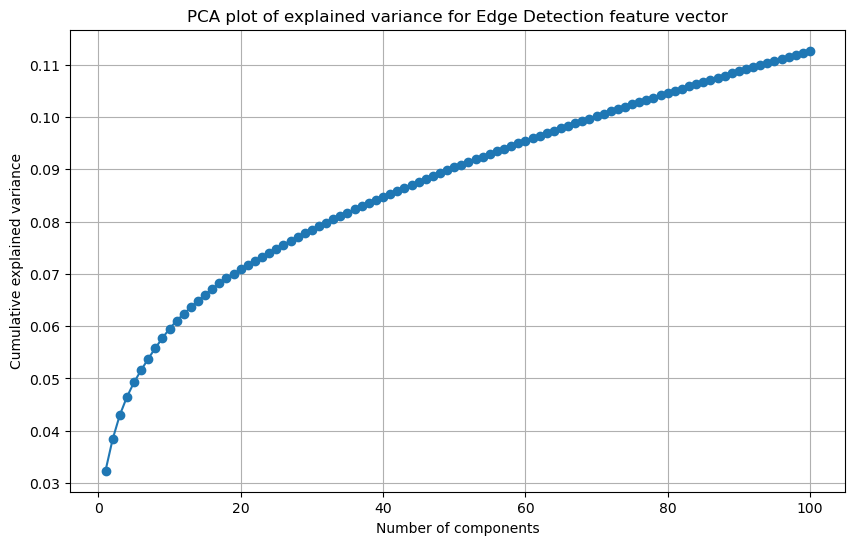

In [ ]:
# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for Edge Detection feature vector')
plt.grid(True)
plt.show()

# Color Histograms

In [ ]:
# Extract features from the preprocessed datasets
X_train, y_train = create_feature_vectors(train_data, [
                                                       # extract_edge_features,
                                                       extract_color_histogram
                                                       ])

X_val, y_val = create_feature_vectors(val_data, [
                                                 # extract_edge_features,
                                                 extract_color_histogram
                                                 ])

X_test, y_test = create_feature_vectors(test_data, [
                                                    # extract_edge_features,
                                                    extract_color_histogram
                                                    ])


In [ ]:
# Apply PCA to reduce dimensionality
n_components = 25  # Adjust based on trade-off between speed and explained variance
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

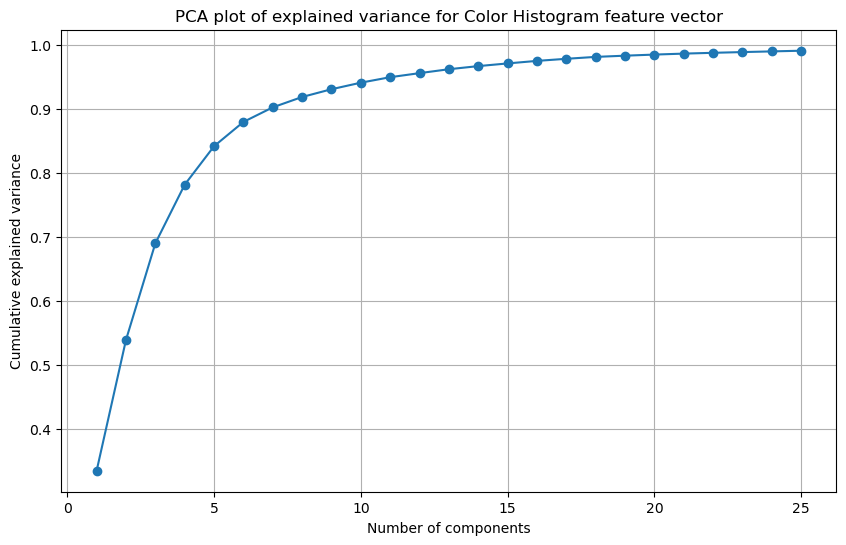

In [ ]:
# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for Color Histogram feature vector')
plt.grid(True)
plt.show()

## Histogram of Oriented Gradients

In [ ]:
def extract_hog_features(image):
    # Convert to grayscale
    gray_image = rgb2gray(image)

    features = hog(
        gray_image,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        visualize=False
    )
    return features

# Create feature vectors using HOG features
X_train, y_train = create_feature_vectors(train_data_preprocessed, [extract_hog_features])
X_val, y_val = create_feature_vectors(val_data_preprocessed, [extract_hog_features])
X_test, y_test = create_feature_vectors(test_data_preprocessed, [extract_hog_features])


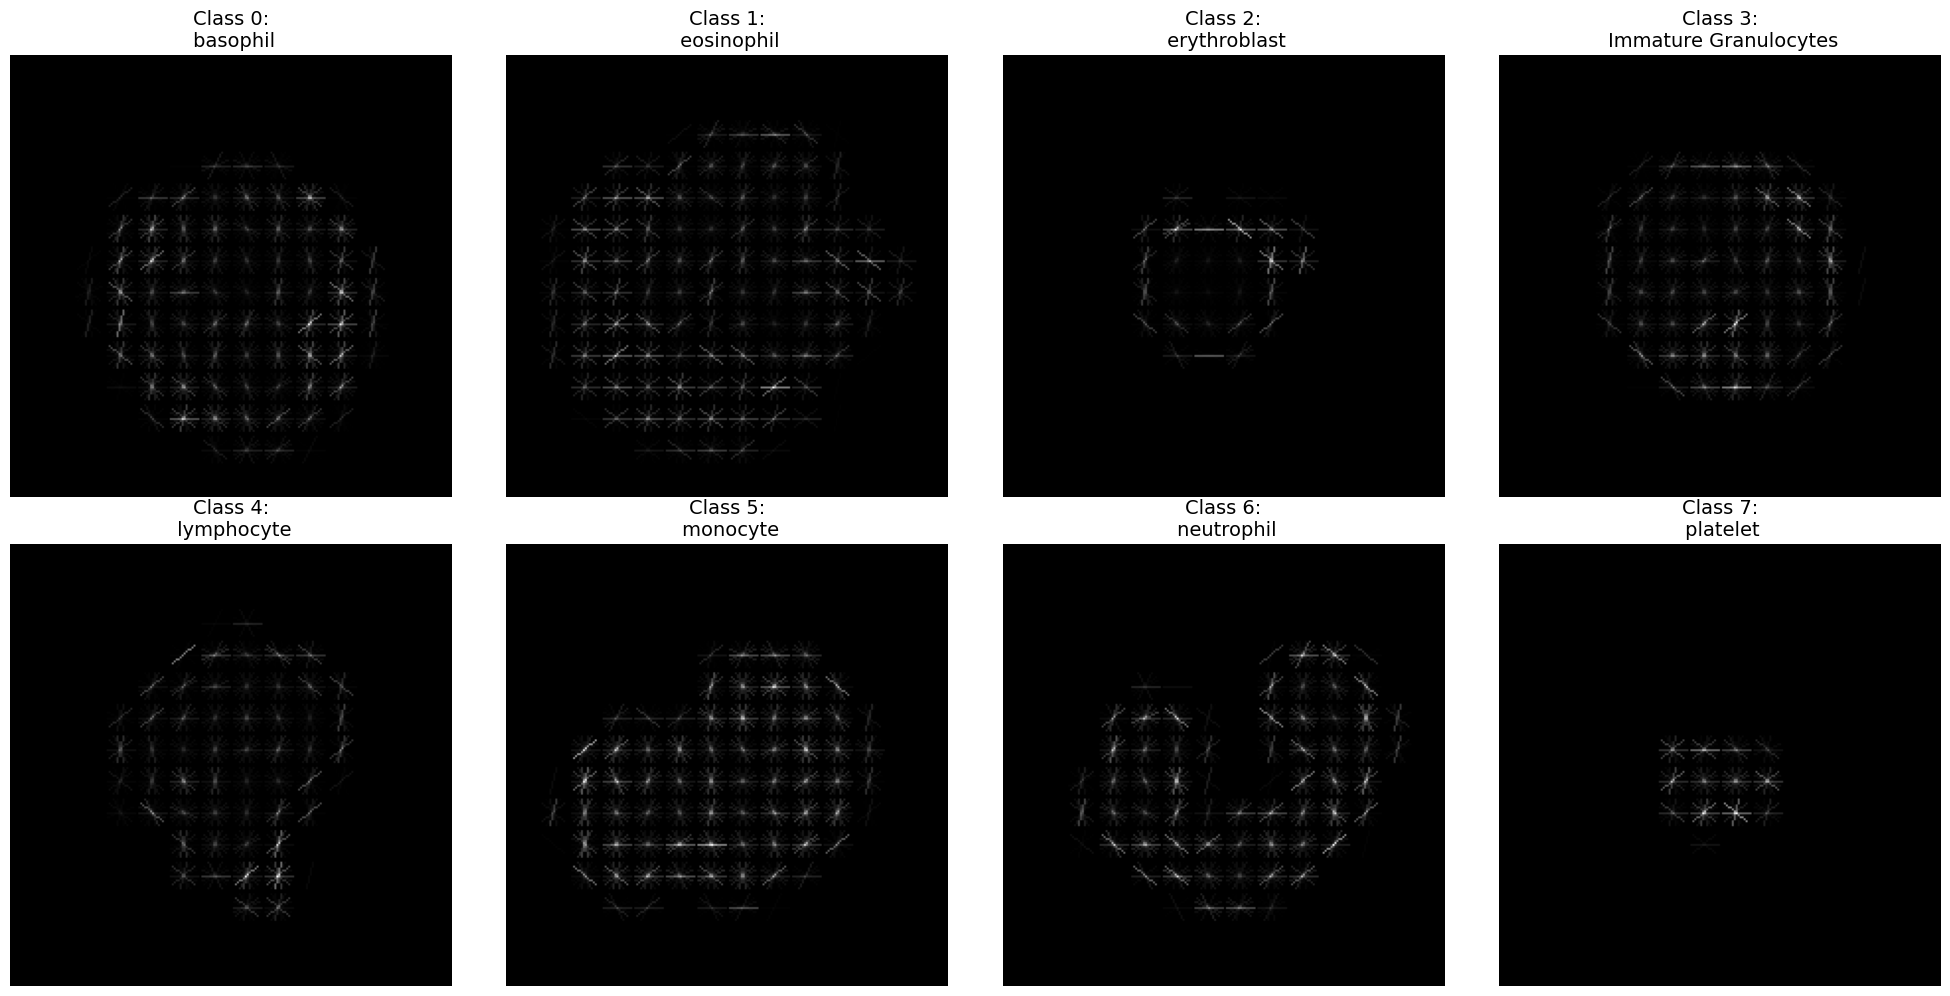

In [ ]:
def show_hog_images_by_class(dataset, n_classes, class_labels):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    class_found = [False] * n_classes

    # Create a dictionary to store images by class
    class_images = {i: [] for i in range(n_classes)}
    for img, label in dataset:
        label = int(label)
        class_images[label].append(img)

    for class_idx in range(n_classes):
        if class_images[class_idx]:
            random_img = random.choice(class_images[class_idx])
            gray_img = rgb2gray(random_img)
            hog_features, hog_image = hog(gray_img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)

            # Plot HOG image
            axes[class_idx].imshow(hog_image, cmap='gray')
            axes[class_idx].set_title(f"Class {class_idx}:\n {class_labels[str(class_idx)]}", fontsize=14)
            axes[class_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Show HOG images for each class
show_hog_images_by_class(train_data_preprocessed, n_classes_blood, class_labels_blood)

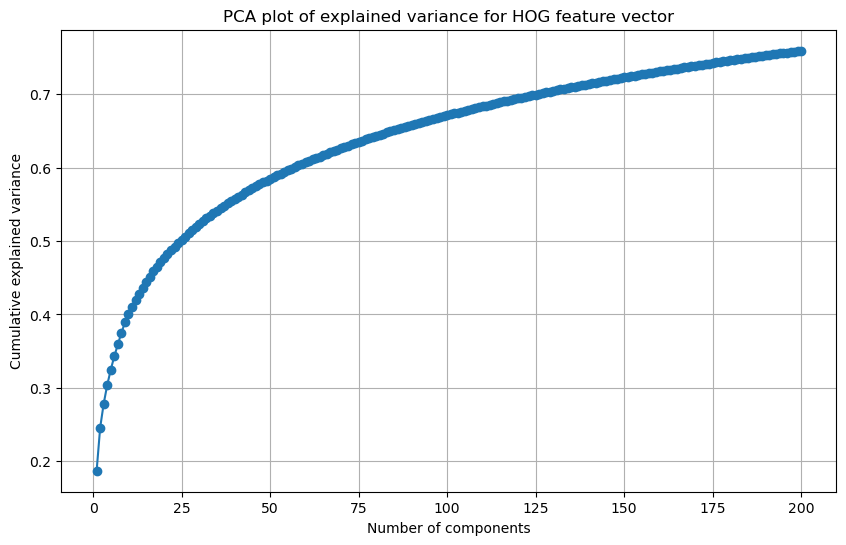

In [ ]:
# Apply PCA to reduce dimensionality
n_components = 200 # Adjust based on trade-off between speed and explained variance
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for HOG feature vector')
plt.grid(True)
plt.show()

# GLCM (Gray-Level Co-Occurrence Matrix)

In [ ]:
# Function to extract GLCM features
def extract_glcm_features(image):
    # Ensure the image is 2D (grayscale)
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Compute the GLCM matrix
    distances = [1]  # Define distances for computing GLCM
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Define angles for computing GLCM
    glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)

    # Compute GLCM properties
    contrast = graycoprops(glcm, 'contrast').flatten()
    dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    ASM = graycoprops(glcm, 'ASM').flatten()

    features = np.hstack([contrast, dissimilarity, homogeneity, energy, correlation, ASM])
    return features

# Extract features from the preprocessed datasets
X_train, y_train = create_feature_vectors(train_data_preprocessed, [extract_glcm_features])
X_val, y_val = create_feature_vectors(val_data_preprocessed, [extract_glcm_features])
X_test, y_test = create_feature_vectors(test_data_preprocessed, [extract_glcm_features])



# GLCM features

**1. High dissimilarity** values indicate greater variation between neighboring pixel values, corresponding to a more complex texture. Low dissimilarity values indicate that pixel values are more uniform or similar, corresponding to a smoother texture.

**2. High homogeneity** values indicate that the image has many similar or identical pixel pairs, which correspond to a smooth or uniform texture. Low homogeneity values indicate that the pixel pairs are less similar, corresponding to a more complex texture.

**3. High energy values** indicate that the GLCM has high values for a few gray-level pairs, which means the texture is very uniform

**4. High correlation values** indicate that there is a strong linear relationship between the gray levels of pixel pairs, meaning that the texture has a regular and predictable pattern. Low correlation values indicate a weaker or no linear relationship, corresponding to a more random texture

**5. High ASM values** indicate that the texture is very regular and uniform. Low ASM values indicate a more disordered or complex texture.

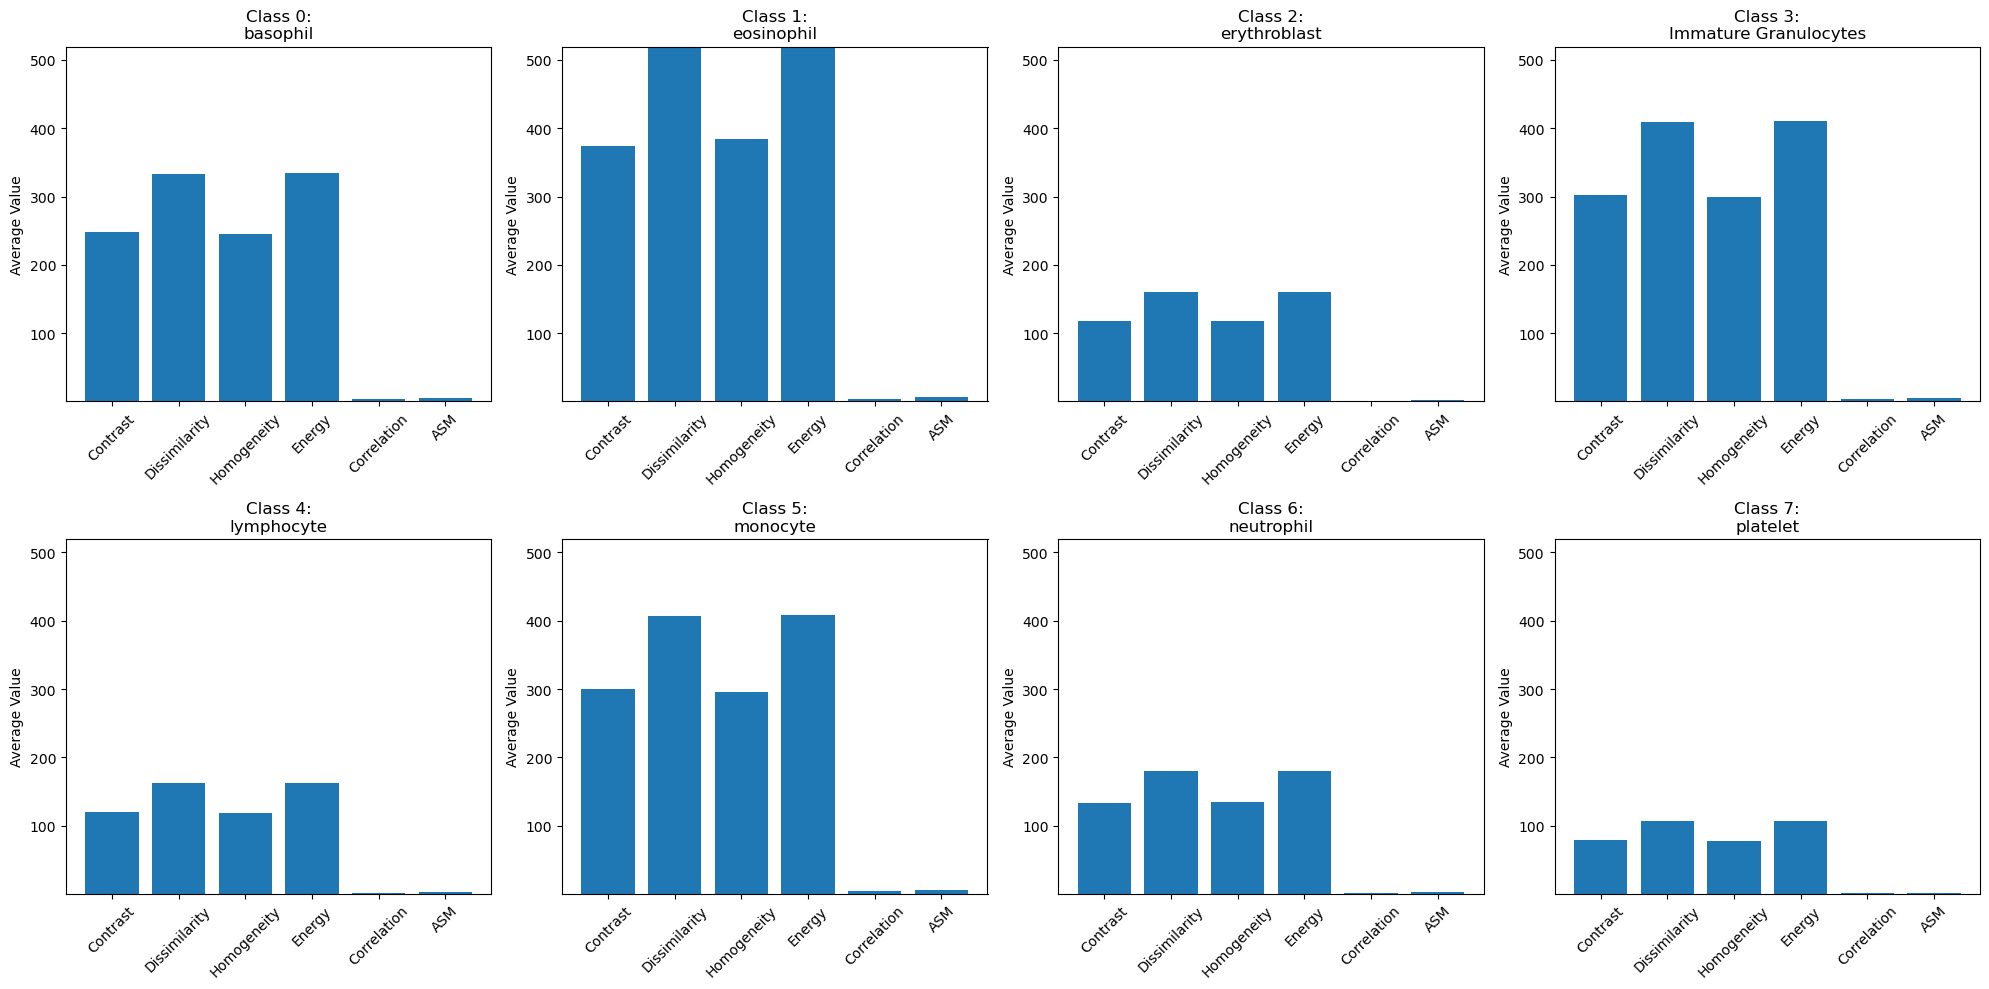

In [ ]:
# Function to display GLCM features for each class

def show_glcm_features_by_class(X, y, n_classes, class_labels):
    features_by_class = {i: [] for i in range(n_classes)}

    # Aggregate features by class
    for features, label in zip(X, y):
        features_by_class[int(label)].append(features)

    # Calculate average features for each class
    avg_features_by_class = {class_idx: np.mean(features, axis=0) for class_idx, features in features_by_class.items()}

    # Determine the global min and max values for y-axis
    all_avg_features = np.array(list(avg_features_by_class.values()))
    y_min = np.min(all_avg_features[:, :6])
    y_max = np.max(all_avg_features[:, :6])

    # Plot the average features for each class
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    feature_names = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'ASM']
    for class_idx, avg_features in avg_features_by_class.items():
        axes[class_idx].bar(feature_names, avg_features[:6])
        axes[class_idx].set_title(f"Class {class_idx}:\n{class_labels[str(class_idx)]}")
        axes[class_idx].set_ylim([y_min - 0.1, y_max + 0.1])
        axes[class_idx].set_ylabel('Average Value')
        axes[class_idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Get the class labels and the number of classes
blood_info = INFO['bloodmnist']
class_labels_blood = blood_info['label']
class_labels_blood['3'] = 'Immature Granulocytes'
n_classes_blood = len(class_labels_blood)

# Show GLCM features for each class
show_glcm_features_by_class(X_train, y_train, n_classes_blood, class_labels_blood)

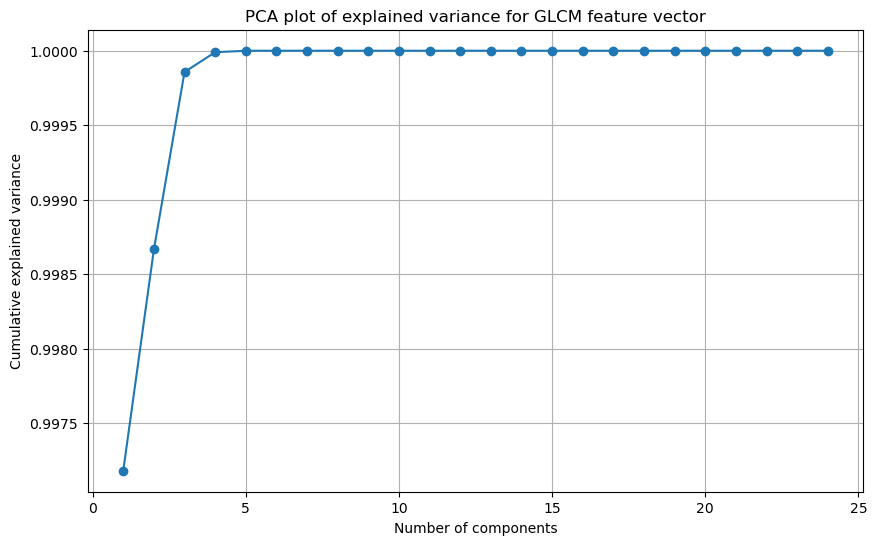

In [ ]:

# Apply PCA to reduce dimensionality
n_components = min(X_train.shape[0], X_train.shape[1])  # Set to the minimum of samples and features
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for GLCM feature vector')
plt.grid(True)
plt.show()

# Build Models

## Logistic Regression (Baseline)

In [ ]:
# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_pca, y_train)

# Evaluate the model
y_train_pred = log_reg.predict(X_train_pca)
y_val_pred = log_reg.predict(X_val_pca)
y_test_pred = log_reg.predict(X_test_pca)

print("Training accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification report (Test):")
print(classification_report(y_test, y_test_pred, target_names=[class_labels_blood[str(i)] for i in range(n_classes_blood)]))

/Users/lowi33/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training accuracy: 0.5987122669119491
Validation accuracy: 0.6016355140186916
Test accuracy: 0.5928091201403098
Classification report (Test):
                       precision    recall  f1-score   support

             basophil       0.48      0.36      0.41       244
           eosinophil       0.75      0.78      0.76       624
         erythroblast       0.53      0.15      0.23       311
Immature Granulocytes       0.38      0.48      0.43       579
           lymphocyte       0.39      0.14      0.20       243
             monocyte       0.46      0.07      0.12       284
           neutrophil       0.61      0.93      0.73       666
             platelet       0.72      0.98      0.83       470

             accuracy                           0.59      3421
            macro avg       0.54      0.48      0.46      3421
         weighted avg       0.57      0.59      0.54      3421



/Users/lowi33/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Random Forest

## XGBoost

## Support Vector Machines

# Plot Results

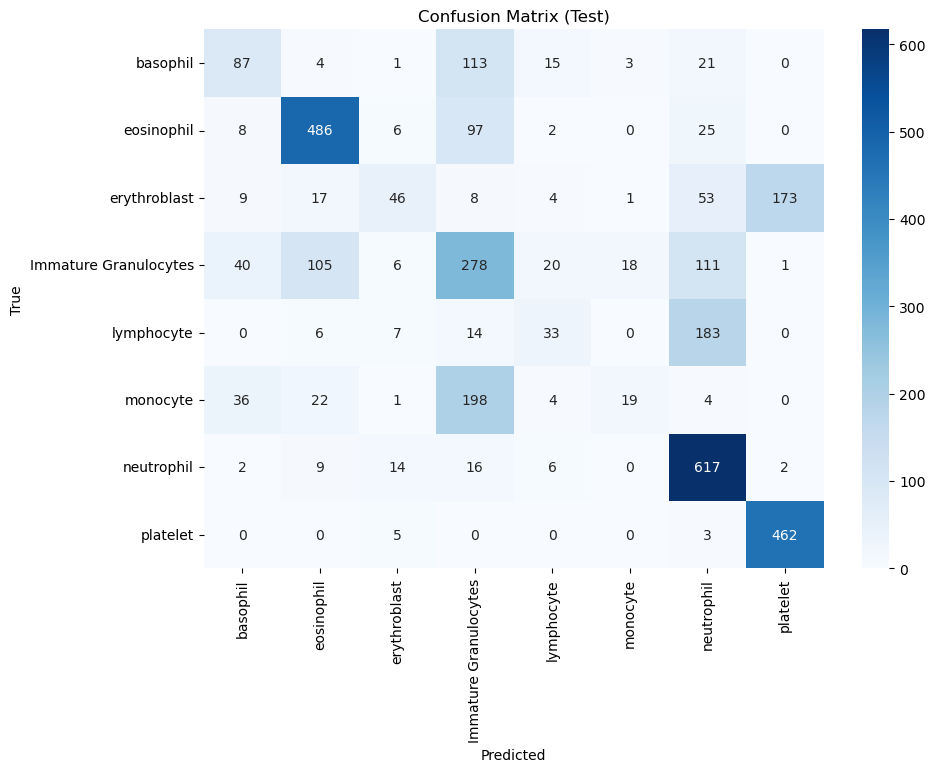

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Plot confusion matrix for test data
plot_confusion_matrix(y_test, y_test_pred, [class_labels_blood[str(i)] for i in range(n_classes_blood)], 'Confusion Matrix (Test)')

# Next Steps

- Explore Additional Features: Consider exploring other features such as texture analysis (e.g., Local Binary Patterns, Gray Level Co-occurrence Matrix) or more advanced shape descriptors.

- Feature Selection: Perform feature selection techniques to identify the most important features for your classification task. This can help reduce the dimensionality and improve model performance.

- Build some additional classifiers like SVM, RF, XGBoost, CNN